In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation, metrics
import tensorflow as tf

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# run environment

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.4)
sess_config = tf.ConfigProto(gpu_options=gpu_options)

# label

In [4]:
labels = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

fault_label = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system','9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

# load data

In [5]:
def one_hot(y):
    y = y.reshape(len(y))
    n_values = np.max(y) + 1
    return np.eye(n_values)[np.array(y, dtype=np.int32)]  # Returns FLOATS


def load_X(X_path):
    X_list = []
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_signal = [np.array(item, dtype=np.float32) for item in [
               line.strip().split('\t') for line in file]]
    X_list.append(X_signal)
    file.close()
    return np.transpose(np.array(X_list), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array([elem for elem in [line.strip().split('\t') for line in file]], 
                  dtype=np.int32)
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return one_hot(y_-1)


dataset_path = "../data_msg_type/"
trainX_path = dataset_path + "semantic_train_x.txt"
trainY_path = dataset_path + "semantic_train_y.txt"
testX_path = dataset_path + "semantic_test_x.txt"
testY_path = dataset_path + "semantic_test_y.txt"


train_x = load_X(trainX_path)
train_y = load_y(trainY_path)
test_x = load_X(testX_path)
test_y = load_y(testY_path)

train_x = train_x.reshape(len(train_x), 10, 14, 1)
test_x = test_x.reshape(len(test_x), 10, 14, 1)

'''
# Separate our training data into test and training.
print("Separating data into 80% training set & 20% test set...")
train_x, test_x, train_y, test_y = cross_validation.train_test_split(
    x, y, test_size=0.2, random_state=33)#add random state here...
'''

print("Dataset separated.\n")
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

Dataset separated.

((80000, 10, 14, 1), (80000, 14), (20000, 10, 14, 1), (20000, 14))


# define parameters

In [6]:
learning_rate = 0.0001
training_iters = 8800000
batch_size = 1000
display_step = 20000

# Network Parameters
input_height = 10
input_width = 14
num_channels = 1
n_classes = 14
dropout = 0.75 # Dropout, probability to keep units

# network config

In [7]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 10, 14, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)
    print(conv1.shape)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)
    print(conv2.shape)

    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # Fully connected layer
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    print(fc1.shape)
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, dropout)
    print(fc2.shape)

    # Output, class prediction
    fc3 = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    print(fc3.shape)
    return fc3

# Store layers weight & bias
weights = {
    # 3x4 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([3, 4, 1, 32])),
    # 3x4 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([3, 4, 32, 64])),
    # fully connected, 2*2*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([3*4*64, 1024])),
    # fully connected, 1024 inputs, 512 outputs
    'wd2': tf.Variable(tf.random_normal([1024, 512])),
    # 512 inputs, 14outputs (class prediction)
    'out': tf.Variable(tf.random_normal([512, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'bd2': tf.Variable(tf.random_normal([512])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# build model

In [8]:
x = tf.placeholder(tf.float32, [None,input_height,input_width,num_channels])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

(?, 5, 7, 32)
(?, 3, 4, 64)
(?, 1024)
(?, 512)
(?, 14)


# train and test

In [9]:
def extract_batch_size(_train, step, batch_size):   
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 
    return batch_s


test_losses = []
test_accuracies = []
test_predictions = []
train_losses = []
train_accuracies = []


init = tf.global_variables_initializer()
with tf.Session(config=sess_config) as sess:
    sess.run(init)
    
    step = 1
    # Keep training until reach max iterations
    while step * batch_size <= training_iters:
        batch_xs = extract_batch_size(train_x, step, batch_size)
        batch_ys = extract_batch_size(train_y, step, batch_size)

        # Fit training using batch data
        _, loss, acc = sess.run([optimizer, cost, accuracy],
                       feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})

        train_losses.append(loss)
        train_accuracies.append(acc)  
        
        
        batch_xt = extract_batch_size(test_x, step, batch_size)
        batch_yt = extract_batch_size(test_y, step, batch_size)
    
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        test_predict, test_loss, test_acc = sess.run([pred, cost, accuracy], 
                                            feed_dict={x: batch_xt, y: batch_yt, keep_prob: 1.})
        
        test_predictions.append(np.argmax(test_predict, axis=1))
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_step == 0) or (step == 1) \
            or (step * batch_size > training_iters):

            print("Training epochs #" + str(step*batch_size) + \
                  ": Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))
        
            print("Performance on test set: " + "Training epochs #" + str(step*batch_size) +\
                  ", Batch Loss = {}".format(test_loss) + ", Accuracy = {}".format(test_acc))
        step += 1

    print("Optimization Finished!")

Training epochs #1000: Batch Loss = 681729.687500, Accuracy = 0.0320000015199
Performance on test set: Training epochs #1000, Batch Loss = 476321.4375, Accuracy = 0.0
Training epochs #20000: Batch Loss = 368662.750000, Accuracy = 0.0659999996424
Performance on test set: Training epochs #20000, Batch Loss = 221648.75, Accuracy = 0.0
Training epochs #40000: Batch Loss = 202823.046875, Accuracy = 0.0460000000894
Performance on test set: Training epochs #40000, Batch Loss = 79469.15625, Accuracy = 0.0140000013635
Training epochs #60000: Batch Loss = 74560.515625, Accuracy = 0.397000014782
Performance on test set: Training epochs #60000, Batch Loss = 22247.7636719, Accuracy = 0.805000066757
Training epochs #80000: Batch Loss = 47991.222656, Accuracy = 0.68799996376
Performance on test set: Training epochs #80000, Batch Loss = 33770.7539062, Accuracy = 0.805000066757
Training epochs #100000: Batch Loss = 269474.250000, Accuracy = 0.069000005722
Performance on test set: Training epochs #10000

Training epochs #920000: Batch Loss = 16127.768555, Accuracy = 0.667999982834
Performance on test set: Training epochs #920000, Batch Loss = 3194.88720703, Accuracy = 0.942999958992
Training epochs #940000: Batch Loss = 10224.293945, Accuracy = 0.851999998093
Performance on test set: Training epochs #940000, Batch Loss = 5853.03125, Accuracy = 0.942999958992
Training epochs #960000: Batch Loss = 7298.039062, Accuracy = 0.894000053406
Performance on test set: Training epochs #960000, Batch Loss = 6500.27441406, Accuracy = 0.943000078201
Training epochs #980000: Batch Loss = 66682.773438, Accuracy = 0.258000016212
Performance on test set: Training epochs #980000, Batch Loss = 1915.18505859, Accuracy = 0.942999958992
Training epochs #1000000: Batch Loss = 14174.843750, Accuracy = 0.695999979973
Performance on test set: Training epochs #1000000, Batch Loss = 2935.78125, Accuracy = 0.943000078201
Training epochs #1020000: Batch Loss = 9947.800781, Accuracy = 0.851999998093
Performance on te

Training epochs #1820000: Batch Loss = 4280.654297, Accuracy = 0.911000013351
Performance on test set: Training epochs #1820000, Batch Loss = 2665.62255859, Accuracy = 0.955000042915
Training epochs #1840000: Batch Loss = 2765.766113, Accuracy = 0.93800008297
Performance on test set: Training epochs #1840000, Batch Loss = 2948.74316406, Accuracy = 0.955000042915
Training epochs #1860000: Batch Loss = 33816.949219, Accuracy = 0.34399998188
Performance on test set: Training epochs #1860000, Batch Loss = 987.950317383, Accuracy = 0.967999994755
Training epochs #1880000: Batch Loss = 6966.350098, Accuracy = 0.798999965191
Performance on test set: Training epochs #1880000, Batch Loss = 1420.49328613, Accuracy = 0.955000042915
Training epochs #1900000: Batch Loss = 3945.254883, Accuracy = 0.904000043869
Performance on test set: Training epochs #1900000, Batch Loss = 2553.13476562, Accuracy = 0.954999983311
Training epochs #1920000: Batch Loss = 2392.644287, Accuracy = 0.93799996376
Performan

Training epochs #2720000: Batch Loss = 1074.957031, Accuracy = 0.956000089645
Performance on test set: Training epochs #2720000, Batch Loss = 1587.77709961, Accuracy = 0.955000042915
Training epochs #2740000: Batch Loss = 15466.296875, Accuracy = 0.469000011683
Performance on test set: Training epochs #2740000, Batch Loss = 569.878723145, Accuracy = 0.991000056267
Training epochs #2760000: Batch Loss = 2659.276367, Accuracy = 0.887000083923
Performance on test set: Training epochs #2760000, Batch Loss = 944.82409668, Accuracy = 0.961000025272
Training epochs #2780000: Batch Loss = 1976.214478, Accuracy = 0.94000005722
Performance on test set: Training epochs #2780000, Batch Loss = 1444.2121582, Accuracy = 0.955000042915
Training epochs #2800000: Batch Loss = 947.487976, Accuracy = 0.953999996185
Performance on test set: Training epochs #2800000, Batch Loss = 1439.3782959, Accuracy = 0.955000042915
Training epochs #2820000: Batch Loss = 14458.617188, Accuracy = 0.495999991894
Performanc

Training epochs #3620000: Batch Loss = 7483.160156, Accuracy = 0.603999972343
Performance on test set: Training epochs #3620000, Batch Loss = 633.556030273, Accuracy = 0.856999993324
Training epochs #3640000: Batch Loss = 1166.202881, Accuracy = 0.93900001049
Performance on test set: Training epochs #3640000, Batch Loss = 751.862548828, Accuracy = 0.961000025272
Training epochs #3660000: Batch Loss = 1402.544434, Accuracy = 0.95500010252
Performance on test set: Training epochs #3660000, Batch Loss = 980.03125, Accuracy = 0.961000025272
Training epochs #3680000: Batch Loss = 352.870972, Accuracy = 0.972999989986
Performance on test set: Training epochs #3680000, Batch Loss = 776.200073242, Accuracy = 0.961000025272
Training epochs #3700000: Batch Loss = 6979.378418, Accuracy = 0.619000017643
Performance on test set: Training epochs #3700000, Batch Loss = 582.060852051, Accuracy = 0.856999993324
Training epochs #3720000: Batch Loss = 936.822388, Accuracy = 0.950000047684
Performance on 

Training epochs #4540000: Batch Loss = 545.166626, Accuracy = 0.968000054359
Performance on test set: Training epochs #4540000, Batch Loss = 383.635559082, Accuracy = 0.961000025272
Training epochs #4560000: Batch Loss = 213.082550, Accuracy = 0.976000010967
Performance on test set: Training epochs #4560000, Batch Loss = 278.539550781, Accuracy = 0.975000083447
Training epochs #4580000: Batch Loss = 4520.593750, Accuracy = 0.697000026703
Performance on test set: Training epochs #4580000, Batch Loss = 265.160858154, Accuracy = 0.991000056267
Training epochs #4600000: Batch Loss = 385.495178, Accuracy = 0.957000076771
Performance on test set: Training epochs #4600000, Batch Loss = 333.134277344, Accuracy = 0.961000025272
Training epochs #4620000: Batch Loss = 586.744995, Accuracy = 0.956000030041
Performance on test set: Training epochs #4620000, Batch Loss = 378.635742188, Accuracy = 0.961000025272
Training epochs #4640000: Batch Loss = 212.728119, Accuracy = 0.971000015736
Performance 

Training epochs #5460000: Batch Loss = 3681.133789, Accuracy = 0.670000016689
Performance on test set: Training epochs #5460000, Batch Loss = 204.757720947, Accuracy = 0.975000023842
Training epochs #5480000: Batch Loss = 154.756546, Accuracy = 0.975000023842
Performance on test set: Training epochs #5480000, Batch Loss = 135.281280518, Accuracy = 0.975000023842
Training epochs #5500000: Batch Loss = 359.586731, Accuracy = 0.968000054359
Performance on test set: Training epochs #5500000, Batch Loss = 148.572738647, Accuracy = 0.975000023842
Training epochs #5520000: Batch Loss = 61.755718, Accuracy = 0.987000048161
Performance on test set: Training epochs #5520000, Batch Loss = 43.3375282288, Accuracy = 0.982000112534
Training epochs #5540000: Batch Loss = 3175.121338, Accuracy = 0.690999984741
Performance on test set: Training epochs #5540000, Batch Loss = 178.150222778, Accuracy = 0.982000052929
Training epochs #5560000: Batch Loss = 137.136017, Accuracy = 0.974999964237
Performance 

Training epochs #6380000: Batch Loss = 163.922516, Accuracy = 0.976999998093
Performance on test set: Training epochs #6380000, Batch Loss = 33.4123954773, Accuracy = 0.988000035286
Training epochs #6400000: Batch Loss = 61.771343, Accuracy = 0.987999975681
Performance on test set: Training epochs #6400000, Batch Loss = 2.34871697426, Accuracy = 0.993000030518
Training epochs #6420000: Batch Loss = 1726.404907, Accuracy = 0.695000052452
Performance on test set: Training epochs #6420000, Batch Loss = 92.0496063232, Accuracy = 0.991000056267
Training epochs #6440000: Batch Loss = 25.140141, Accuracy = 0.985999941826
Performance on test set: Training epochs #6440000, Batch Loss = 51.9837265015, Accuracy = 0.981000006199
Training epochs #6460000: Batch Loss = 87.792580, Accuracy = 0.974000036716
Performance on test set: Training epochs #6460000, Batch Loss = 31.2471923828, Accuracy = 0.988000035286
Training epochs #6480000: Batch Loss = 35.936878, Accuracy = 0.990999937057
Performance on t

Training epochs #7300000: Batch Loss = 678.121521, Accuracy = 0.788000047207
Performance on test set: Training epochs #7300000, Batch Loss = 11.1374874115, Accuracy = 0.991000056267
Training epochs #7320000: Batch Loss = 12.782893, Accuracy = 0.987000048161
Performance on test set: Training epochs #7320000, Batch Loss = 4.28163909912, Accuracy = 0.983000040054
Training epochs #7340000: Batch Loss = 27.937702, Accuracy = 0.989000082016
Performance on test set: Training epochs #7340000, Batch Loss = 1.44003427029, Accuracy = 0.999000072479
Training epochs #7360000: Batch Loss = 13.854633, Accuracy = 0.990000009537
Performance on test set: Training epochs #7360000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7380000: Batch Loss = 458.405823, Accuracy = 0.825000047684
Performance on test set: Training epochs #7380000, Batch Loss = 7.54893875122, Accuracy = 0.991000056267
Training epochs #7400000: Batch Loss = 12.370123, Accuracy = 0.989000022411
Performance on test set: Tra

Training epochs #8240000: Batch Loss = 0.124926, Accuracy = 0.999000072479
Performance on test set: Training epochs #8240000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #8260000: Batch Loss = 97.458687, Accuracy = 0.891000032425
Performance on test set: Training epochs #8260000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #8280000: Batch Loss = 4.366402, Accuracy = 0.978000044823
Performance on test set: Training epochs #8280000, Batch Loss = 0.667657017708, Accuracy = 0.990999996662
Training epochs #8300000: Batch Loss = 1.151227, Accuracy = 0.995000004768
Performance on test set: Training epochs #8300000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #8320000: Batch Loss = 0.262762, Accuracy = 0.996000051498
Performance on test set: Training epochs #8320000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #8340000: Batch Loss = 70.104362, Accuracy = 0.917999982834
Performance on test set: Training epochs #8340000, Batch Loss = 0.0, Accuracy = 1.0
Tr

# performance visualization

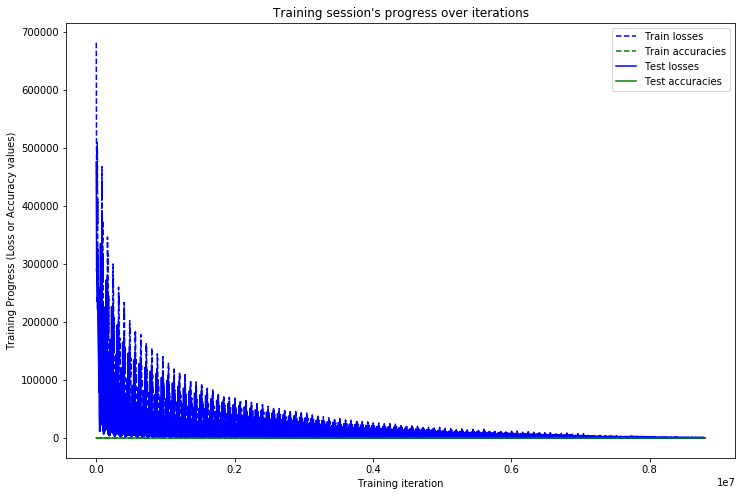

In [10]:
#font = {'family': 'Bitstream Vera Sans', 'weight': 'bold', 'size': 12}
#matplotlib.rc('font', **font)
width = 12
height = 8
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, 
                   (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses), "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(np.array(range(batch_size, 
                  len(test_losses)*batch_size, batch_size)), training_iters)
plt.plot(indep_test_axis, np.array(test_losses), "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=False)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')
plt.savefig('result/lstm_loss_accuracy.png')
plt.figure()
plt.show()

Best Testing Accuracy: 100.000011921%

Precision: 95.9766978122%
Recall: 94.435%
f1_score: 94.9363678413%

Confusion Matrix:
[[    0    18     0     0     0     0     0     0     0     0     0     0
      0]
 [    3   535     0     0   105    81    40     1     0     5     0     7
    134]
 [    0     0   213     0     0     0     0     0     0     0     0     0
      0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      2]
 [    0     0     0     0  2769    41     0    10     0     0     0     4
     67]
 [    3    56     0     0     3   264     8     1     0     0     1     0
     12]
 [    0     7     0     0     0     0 14486     0     0     0     0     0
      2]
 [    0    24     0     1    59    27    42   333     0     0     4     4
     41]
 [    0     0     0     0     0     0     0     0     0   132     0     0
      0]
 [    0     0     0     0     0     0     0     0     0     2     0     0
      2]
 [    8     0     0     0     0     0     0  

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


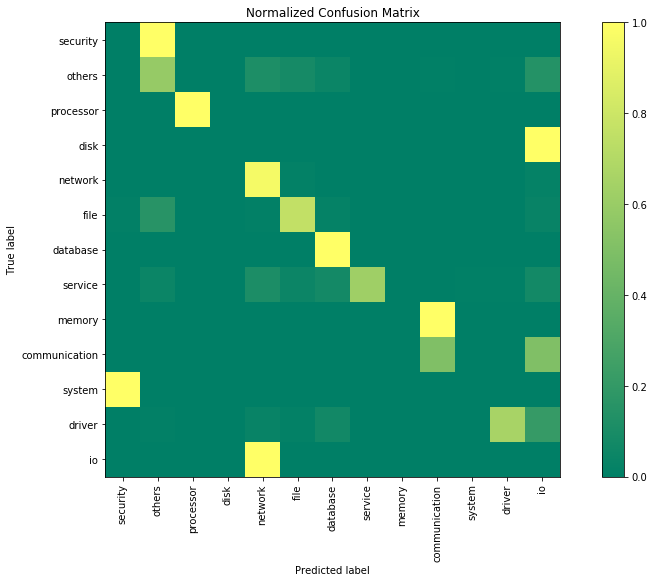

In [11]:
# Results
predictions = []
length = len(test_predictions)-20
for i in range(20):
    predictions.extend(test_predictions[length+i])

true_y = np.argmax(test_y, axis=1)

print("Best Testing Accuracy: {}%".format(100*max(test_accuracies)))

print("")
print("Precision: {}%".format(100*metrics.precision_score(
    true_y, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(true_y, 
    predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(true_y, 
    predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(true_y, predictions)
print(confusion_matrix)

# Plot: 
## cmap can be changed to many colors, (colormaps.Oranges,OrRd, etc)
def plot_CM(cm, title="Normalized Confusion Matrix", cmap=plt.cm.summer):
    width = 12
    height = 8
    plt.figure(figsize=(width, height))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(fault_label))
    plt.xticks(tick_marks, fault_label.values(), rotation=90)
    plt.yticks(tick_marks, fault_label.values())
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
print(metrics.classification_report(
    true_y, predictions, target_names = list(labels.values())))

cm = confusion_matrix

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
plt.figure()
plot_CM(cm_normalized)